In [1]:
#figdir = '/home/kpmurphy/github/rebayes/demos/figures' # TPU
figdir = '/Users/kpmurphy/github/rebayes/demos/figures' # laptop

In [2]:
import jax
#import distrax
import jax.numpy as jnp
import jax.random as jr
from jax.flatten_util import ravel_pytree
from jax import vmap
import flax.linen 
import flax.linen as nn
#import jax_dataloader.core as jdl

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
from typing import Callable
from tqdm.notebook import tqdm
import itertools
from itertools import product
import time
import copy

import rebayes
from rebayes import base
from rebayes.extended_kalman_filter import ekf
from rebayes.low_rank_filter import lofi, lrvga
from rebayes.sgd_filter import sgd





<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Data

In [3]:

def make_1d_regression(n_train=100, n_test=100, key=0, sort_data=False, coef=jnp.array([2.0,3.0])):
    if isinstance(key, int): key = jr.PRNGKey(key)
    key1, key2, subkey1, subkey2, key_shuffle = jr.split(key, 5)

    def gen1(key, x):
        epsilons = jr.normal(key, shape=(3,))*0.02
        return (x + 0.3*jnp.sin(coef[0]*jnp.pi*(x+epsilons[0])) +
                0.3*jnp.sin(coef[1]*jnp.pi*(x+epsilons[1])) + epsilons[2])
    
    def gen(key, x):
        # coef0 = phase, coef1=freq
        noise = jr.normal(key, shape=(1,))*0.02
        return (x + 0.3*jnp.sin(coef[0] + coef[1]*jnp.pi*x))+noise
    
    X_train = jr.uniform(key1, shape=(n_train, 1), minval=-0.5, maxval=0.5)
    X_test = jr.uniform(key2, shape=(n_test, 1), minval=-0.5, maxval=0.5)
    
    keys_train = jr.split(subkey1, X_train.shape[0])
    keys_test = jr.split(subkey2, X_test.shape[0])
    y_train = vmap(gen)(keys_train, X_train)
    y_test = vmap(gen)(keys_test, X_test)

    # Standardize dataset
    if 0:
        X_train = (X_train - X_train.mean()) / X_train.std()
        y_train = (y_train - y_train.mean()) / y_train.std()
        X_test = (X_test - X_test.mean()) / X_test.std()
        y_test = (y_test - y_test.mean()) / y_test.std()

    return X_train, y_train, X_test, y_test

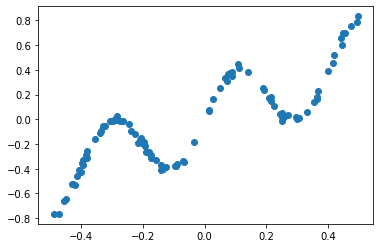

In [4]:

X_train, y_train, X_test, y_test = make_1d_regression(coef=jnp.array([0.0, 5.0]))
plt.figure()
plt.plot(X_train, y_train, 'o')

In [5]:
def make_coef(n_dist = 9, start=2, stop=-2, sf=3, key=0):
    if isinstance(key, int): key = jr.PRNGKey(key)
    key1, key2, key = jr.split(key, 3)
    c0 = jr.uniform(key1,  shape=(n_dist,), minval=-5, maxval=5)
    #c0 = jnp.linspace(start=start, stop=stop, num=n_dist) # phase
    #c1 = sf*c0 # jnp.linspace(start=-1, stop=2, num=n_dist)
    #c1 = jnp.ones(n_dist) * sf # frequency
    c1 = jr.uniform(key2,  shape=(n_dist,), minval=-5, maxval=5)
    coefs = jnp.vstack([c0,c1]).T
    return coefs


def make_regression_tasks(coefs, n_train=100, n_test=100, key=0):
    n_dist = coefs.shape[0]
    def gen(c): return make_1d_regression(coef=c, n_train=n_train, n_test=n_test, key=key)
    X_train, y_train, X_test, y_test  = vmap(gen)(coefs)
    return X_train, y_train, X_test, y_test


def concatenate_tasks(X_train, y_train, X_test, y_test):
    n_dist, n_train, d_train = X_train.shape
    n_dist, n_test, d_test = X_test.shape
    X_train = jnp.hstack(X_train[:,:,0])
    X_test = jnp.hstack(X_test[:,:,0])
    y_train = jnp.hstack(y_train[:,:,0])
    y_test = jnp.hstack(y_test[:,:,0])
    task_id_train = jnp.concatenate([i*jnp.ones(n_train, dtype=int) for i in range(n_dist)])
    task_id_test = jnp.concatenate([i*jnp.ones(n_test, dtype=int) for i in range(n_dist)])
    #return X_train, y_train, X_test, y_test, task_id_train, task_id_test
    return X_train[:,jnp.newaxis], y_train[:,jnp.newaxis], X_test[:,jnp.newaxis], y_test[:,jnp.newaxis], task_id_train, task_id_test

def make_1d_regression_sequence(coefs, n_train=100, n_test=100, key=0):
    X_train, y_train, X_test, y_test = make_regression_tasks(coefs, n_train, n_test, key)
    X_train_seq, y_train_seq, X_test_seq, y_test_seq, train_id_seq, test_id_seq = concatenate_tasks(X_train, y_train, X_test, y_test)
    return X_train_seq, y_train_seq, X_test_seq, y_test_seq, train_id_seq, test_id_seq

In [6]:
def plot_tasks(X_train, Y_train, X_test, Y_test, nr=None, nc=None):
    ntasks = X_train.shape[0]
    colors = plt.cm.tab10(np.arange(ntasks) + 1)
    if nr is None:
        nr = int(np.floor(np.sqrt(ntasks)))
        nc = int(np.ceil(np.sqrt(ntasks)))
    #fig, axs = plt.subplots(1,ntasks, figsize=(20,5))
    fig, axs = plt.subplots(nr, nc, figsize=(10,10))
    axs = axs.flat
    for i in range(ntasks):
        ax = axs[i]
        ax.plot(X_train[i], Y_train[i], 'x', markersize=12, color=colors[i], label='train {:d}'.format(i))
        ax.plot(X_test[i], Y_test[i], 'o', color=colors[i], label='test {:d}'.format(i))
        ax.set_title(i)
    #plt.legend()


def plot_tasks_together(X_train, Y_train, X_test, Y_test, task_id_train, task_id_test):
    ntasks = len(np.unique(task_id_train))
    colors = plt.cm.tab10(np.arange(ntasks) + 1)
    plt.figure()
    for i in range(ntasks):
        ndx_train = (task_id_train == i)
        plt.plot(X_train[ndx_train], Y_train[ndx_train], 'x', color=colors[i], label='train {:d}'.format(i))
        ndx_test = (task_id_test == i)
        plt.plot(X_test[ndx_test], Y_test[ndx_test], 'o', color=colors[i], label='test {:d}'.format(i))
    plt.legend()

def plot_tasks_separately(X_train, Y_train, X_test, Y_test, task_id_train, task_id_test):
    ntasks = len(np.unique(task_id_train))
    colors = plt.cm.tab10(np.arange(ntasks) + 1)
    nr = int(np.floor(np.sqrt(ntasks)))
    nc = int(np.ceil(np.sqrt(ntasks)))
    #fig, axs = plt.subplots(1,ntasks, figsize=(20,5))
    fig, axs = plt.subplots(nr, nc, figsize=(10,10))
    axs = axs.flat
    for i in range(ntasks):
        ax = axs[i]
        ndx_train = (task_id_train == i)
        ax.plot(X_train[ndx_train], Y_train[ndx_train], 'x', color=colors[i], label='train {:d}'.format(i))
        ndx_test = (task_id_test == i)
        ax.plot(X_test[ndx_test], Y_test[ndx_test], 'o', color=colors[i], label='test {:d}'.format(i))
        ax.set_title(i)
    #plt.legend()

[[-4.664 -1.405]
 [ 3.818 -4.835]
 [ 0.27   3.654]
 [ 1.353  2.933]
 [ 1.475 -3.422]
 [-2.432 -0.034]
 [ 0.753 -2.224]
 [ 1.742  1.591]
 [-1.329  1.036]]
(9, 20, 1) (9, 20, 1)
(180, 1) (180, 1)


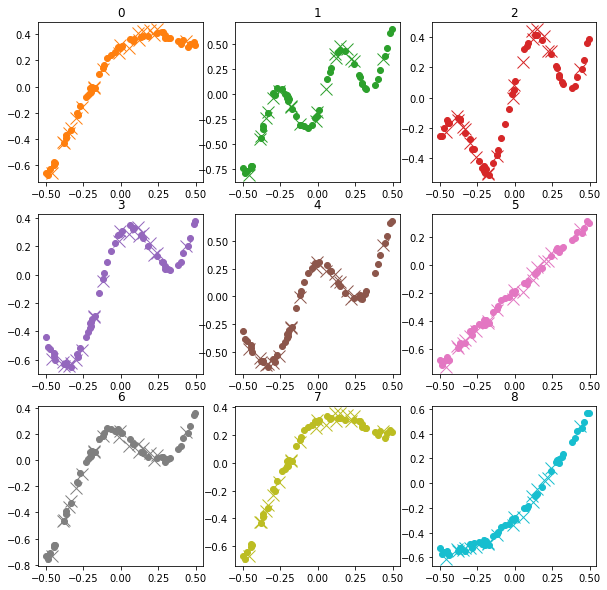

In [7]:


coefs = make_coef(n_dist = 9)

with np.printoptions(precision=3, suppress=True):
    print(coefs)
    

X_train_tasks, Y_train_tasks, X_test_tasks, Y_test_tasks = make_regression_tasks(coefs, n_train=20, n_test=50, key=0)

X_train_seq, Y_train_seq, X_test_seq, Y_test_seq, train_id_seq, test_id_seq = concatenate_tasks(
    X_train_tasks, Y_train_tasks, X_test_tasks, Y_test_tasks)

print(X_train_tasks.shape, Y_train_tasks.shape)
print(X_train_seq.shape, Y_train_seq.shape)

plot_tasks(X_train_tasks, Y_train_tasks, X_test_tasks, Y_test_tasks)

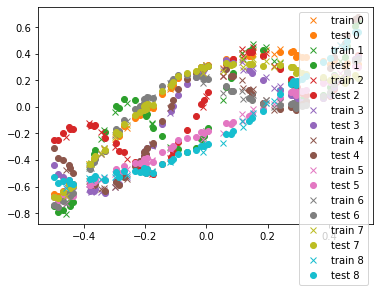

In [8]:
plot_tasks_together(X_train_seq, Y_train_seq, X_test_seq, Y_test_seq, train_id_seq, test_id_seq)

# Rebayes

In [12]:
class MLP(flax.linen.Module):
    n_in: int
    n_out: int
    n_hidden: int = 100
    activation: Callable = flax.linen.relu
    
    @flax.linen.compact
    def __call__(self, x):
        x = flax.linen.Dense(self.n_hidden)(x)
        x = self.activation(x)
        x = flax.linen.Dense(self.n_out)(x)
        return x

def make_bnn_flax(nhidden = 100):    
    key = jax.random.PRNGKey(314)
    dim_out = 1
    dim_in = 1 
    model = MLP(dim_in, dim_out, nhidden)
    params = model.init(key, jnp.ones((1, dim_in)))
    flat_params, recfn = ravel_pytree(params)
    n_params = len(flat_params)
    return model, params, flat_params, recfn

def inspect_model(model, params, flat_params):
    inputs = jnp.ones((1, model.n_in))
    print(model.tabulate(jax.random.PRNGKey(0), inputs))
    b0 = params['params']['Dense_0']['bias']
    w0 = params['params']['Dense_0']['kernel'].squeeze()
    b1 = params['params']['Dense_1']['bias']
    w1 = params['params']['Dense_1']['kernel'].squeeze()
    fp = jnp.concatenate([b0, w0, b1, w1])
    #print(b0.shape, fp.shape, flat_params.shape)
    assert jnp.allclose(fp, flat_params)
    assert jnp.allclose(fp[:model.n_hidden], b0)
    assert jnp.allclose(b0, jnp.zeros(model.n_hidden))

model, dnn_params, flat_params, recfn = make_bnn_flax()
inspect_model(model, dnn_params, flat_params)



                                  MLP Summary                                  
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs         ┃ outputs        ┃ params                 ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ MLP    │ float32[1,1]   │ float32[1,1]   │                        │
├─────────┼────────┼────────────────┼────────────────┼────────────────────────┤
│ Dense_0 │ Dense  │ float32[1,1]   │ float32[1,100] │ bias: float32[100]     │
│         │        │                │                │ kernel: float32[1,100] │
│         │        │                │                │                        │
│         │        │                │                │ 200 (800 B)            │
├─────────┼────────┼────────────────┼────────────────┼────────────────────────┤
│ Dense_1 │ Dense  │ float32[1,100] │ float32[1,1]   │ bias: float32[1]       │
│         │        │                │  

301
(4, 200, 1) (4, 200, 1)
(800, 1) (800, 1)


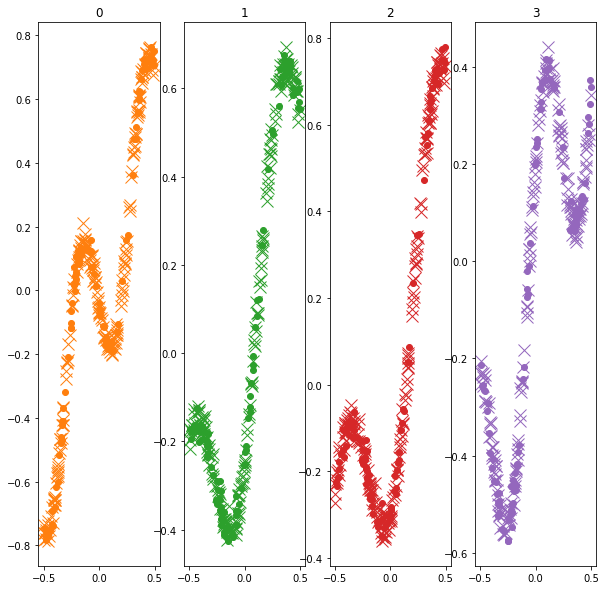

In [13]:
model, dnn_params, flat_params, recfn = make_bnn_flax()
print(len(flat_params))

def apply(flat_params, x, model, unflatten_fn):
    return model.apply(unflatten_fn(flat_params), x)

apply_fn = partial(apply, model=model, unflatten_fn=recfn)

ssm_params = base.RebayesParams(
        initial_mean=flat_params,
        initial_covariance=0.01,
        dynamics_weights=1,
        dynamics_covariance=0.01,
        emission_mean_function=apply_fn,
        emission_cov_function = lambda w,x: 0.1,
        adaptive_emission_cov=False,
        dynamics_covariance_inflation_factor=0.01,
    )


ntasks = 4
coefs = make_coef(n_dist = ntasks, key=42)
X_train_tasks, Y_train_tasks, X_test_tasks, Y_test_tasks = make_regression_tasks(coefs, n_train=200, n_test=100, key=0)

X_train_seq, Y_train_seq, X_test_seq, Y_test_seq, train_id_seq, test_id_seq = concatenate_tasks(
    X_train_tasks, Y_train_tasks, X_test_tasks, Y_test_tasks)

print(X_train_tasks.shape, Y_train_tasks.shape)
print(X_train_seq.shape, Y_train_seq.shape)

plot_tasks(X_train_tasks, Y_train_tasks, X_test_tasks, Y_test_tasks, nr=1, nc=ntasks)

# callback depends on the test set
def callback(bel, pred_obs, t, Xt, Yt, bel_pred, **kwargs):
    #jax.debug.print("time={t}", t=t)

    # eval on all tasks test set
    yhat = apply_fn(bel.mean, X_test_seq).squeeze()
    ytrue = Y_test_seq.squeeze()
    rmse_test_all_tasks = jnp.mean(jnp.square(yhat - ytrue)) 

    # eval on current task 
    task = train_id_seq[t]
    yhat = apply_fn(bel.mean, X_test_tasks[task]).squeeze()
    ytrue = Y_test_tasks[task].squeeze()
    rmse_test_current_task = jnp.sqrt(jnp.mean(jnp.square(yhat - ytrue)))
    mae_test_current_task = jnp.mean(jnp.abs(yhat - ytrue))

    out = {'rmse_test_all_tasks': rmse_test_all_tasks,
           'rmse_test_current_task': rmse_test_current_task,
           'mae_test_current_task': mae_test_current_task,
           'pred_test_current_task': yhat,
           }
    return out





In [32]:
colors = plt.cm.tab10(np.arange(nmethods) + 1)
color_list, style_list, marker_list = [], [], []

global color_counter
color_counter = 0

def get_color():
    global color_counter
    col = colors[color_counter,:]
    color_counter += 1
    return col

print(get_color())
print(get_color())
print(get_color())

[1.         0.49803922 0.05490196 1.        ]
[0.17254902 0.62745098 0.17254902 1.        ]
[0.83921569 0.15294118 0.15686275 1.        ]


In [33]:
method_list, estimator_list = [], []

memory_list = [5,50]
ss_list = [False, True]
alpha_list = [0, 0.01]
combos = itertools.product(memory_list, ss_list, alpha_list)


for (mem, ss, alpha) in combos:
    method = "lofi mem{:d}, ss{:d}, alpha{:0.2f}".format(mem, ss, alpha)
    lofi_params = lofi.LoFiParams(memory_size=mem, steady_state=ss)
    my_ssm_params = copy.deepcopy(ssm_params)
    my_ssm_params = my_ssm_params.replace(dynamics_covariance_inflation_factor = alpha)
    estimator = lofi.RebayesLoFi(my_ssm_params, lofi_params, method="lofi")
    method_list.append(method)
    estimator_list.append(estimator)


method = 'fcekf'
estimator = ekf.RebayesEKF(ssm_params, method=method)
method_list.append(method)
estimator_list.append(estimator)


if 0:
    method = 'vdekf'
    estimator = ekf.RebayesEKF(ssm_params, method=method)
    method_list.append(method)
    estimator_list.append(estimator)

    method = 'fdekf'
    estimator = ekf.RebayesEKF(ssm_params, method=method)
    method_list.append(method)
    estimator_list.append(estimator)

rmse_trace_list, elapsed_list, output_list  = [], [], []

for i, estimator in enumerate(estimator_list):
    t0 = time.time()
    bel, outputs = estimator.scan(X_train_seq, Y_train_seq, callback=callback)
    t1 = time.time()
    elapsed = t1-t0
    elapsed_list.append(elapsed)
    output_list.append(outputs)





In [37]:
print(method_list)

['lofi mem5, ss0, alpha0.00', 'lofi mem5, ss0, alpha0.01', 'lofi mem5, ss1, alpha0.00', 'lofi mem5, ss1, alpha0.01', 'lofi mem50, ss0, alpha0.00', 'lofi mem50, ss0, alpha0.01', 'lofi mem50, ss1, alpha0.00', 'lofi mem50, ss1, alpha0.01', 'fcekf']


In [50]:


combos = itertools.product(memory_list, ss_list, alpha_list)
ncombos = len(list(combos))
nmethods = ncombos + 1
colors = plt.cm.tab10(np.arange(nmethods) + 1)

global color_counter
color_counter = 0

def get_color():
    global color_counter
    col = colors[color_counter,:]
    color_counter += 1
    return col

def get_style(ss, alpha):
    if (ss==False) and (alpha==0):
        return ':'
    elif (ss==True) and (alpha==0):
        return '--'
    elif (ss==False) and (alpha>0):
        return ':'
    elif (ss==True) and (alpha>0):
        return '--'
    
def get_marker(ss, alpha):
    if (ss==False) and (alpha==0):
        return 'o'
    elif (ss==True) and (alpha==0):
        return 'o'
    elif (ss==False) and (alpha>0):
        return 'x'
    elif (ss==True) and (alpha>0):
        return 'x'
    
# Must recompute iterator
#https://stackoverflow.com/questions/32074543/how-to-get-the-length-of-an-itertools-product
combos = itertools.product(memory_list, ss_list, alpha_list)

color_list, style_list, marker_list = [], [], []

for (mem, ss, alpha) in combos:
    color_list.append(get_color())
    style_list.append(get_style(ss, alpha))
    marker_list.append(get_marker(ss, alpha))

color_list.append(get_color())
style_list.append('-')
marker_list.append('*')

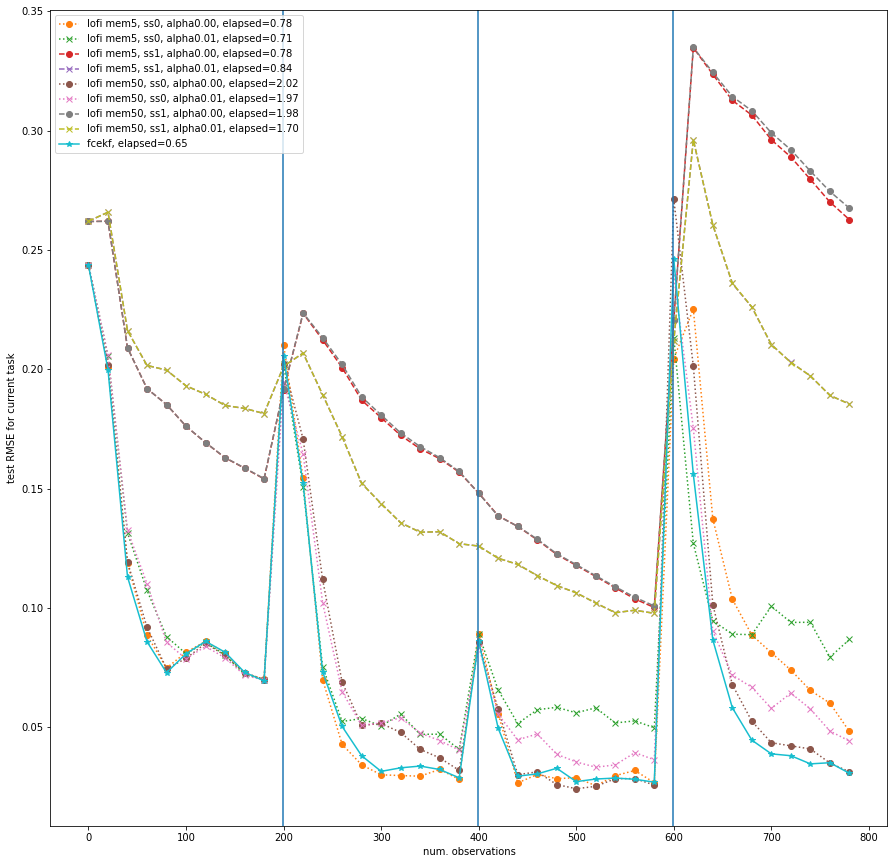

In [52]:
ntasks, ntrain_per_task, _ = X_train_tasks.shape
changepoints = np.arange(ntrain_per_task, (ntasks)*ntrain_per_task, step=ntrain_per_task)-1

plt.figure(figsize=(15,15))
for i, method in enumerate(method_list):
    ttl = '{:s}, elapsed={:0.2f}'.format(method, elapsed_list[i])
    kernel_size = 20
    kernel = jnp.ones(kernel_size) / kernel_size
    rmse_trace = output_list[i]['rmse_test_current_task']
    rmse_smoothed = jnp.convolve(rmse_trace, kernel, mode='same')
    #rmse_smoothed = rmse_trace
    ndata = len(rmse_smoothed)
    ndx = np.arange(0, ndata, step=20) # thin the data so we can see the markers
    plt.plot(ndx, rmse_smoothed[ndx], label=ttl, color=color_list[i], linestyle=style_list[i], marker=marker_list[i])
#plt.ylim([0, 1.5])
for c in changepoints:
    plt.axvline(x=c)
plt.legend()
plt.ylabel('test RMSE for current task')
plt.xlabel('num. observations')


plt.savefig(figdir + '/regression_plot_1d_lofi.pdf')
plt.savefig(figdir + '/regression_plot_1d_lofi.png')

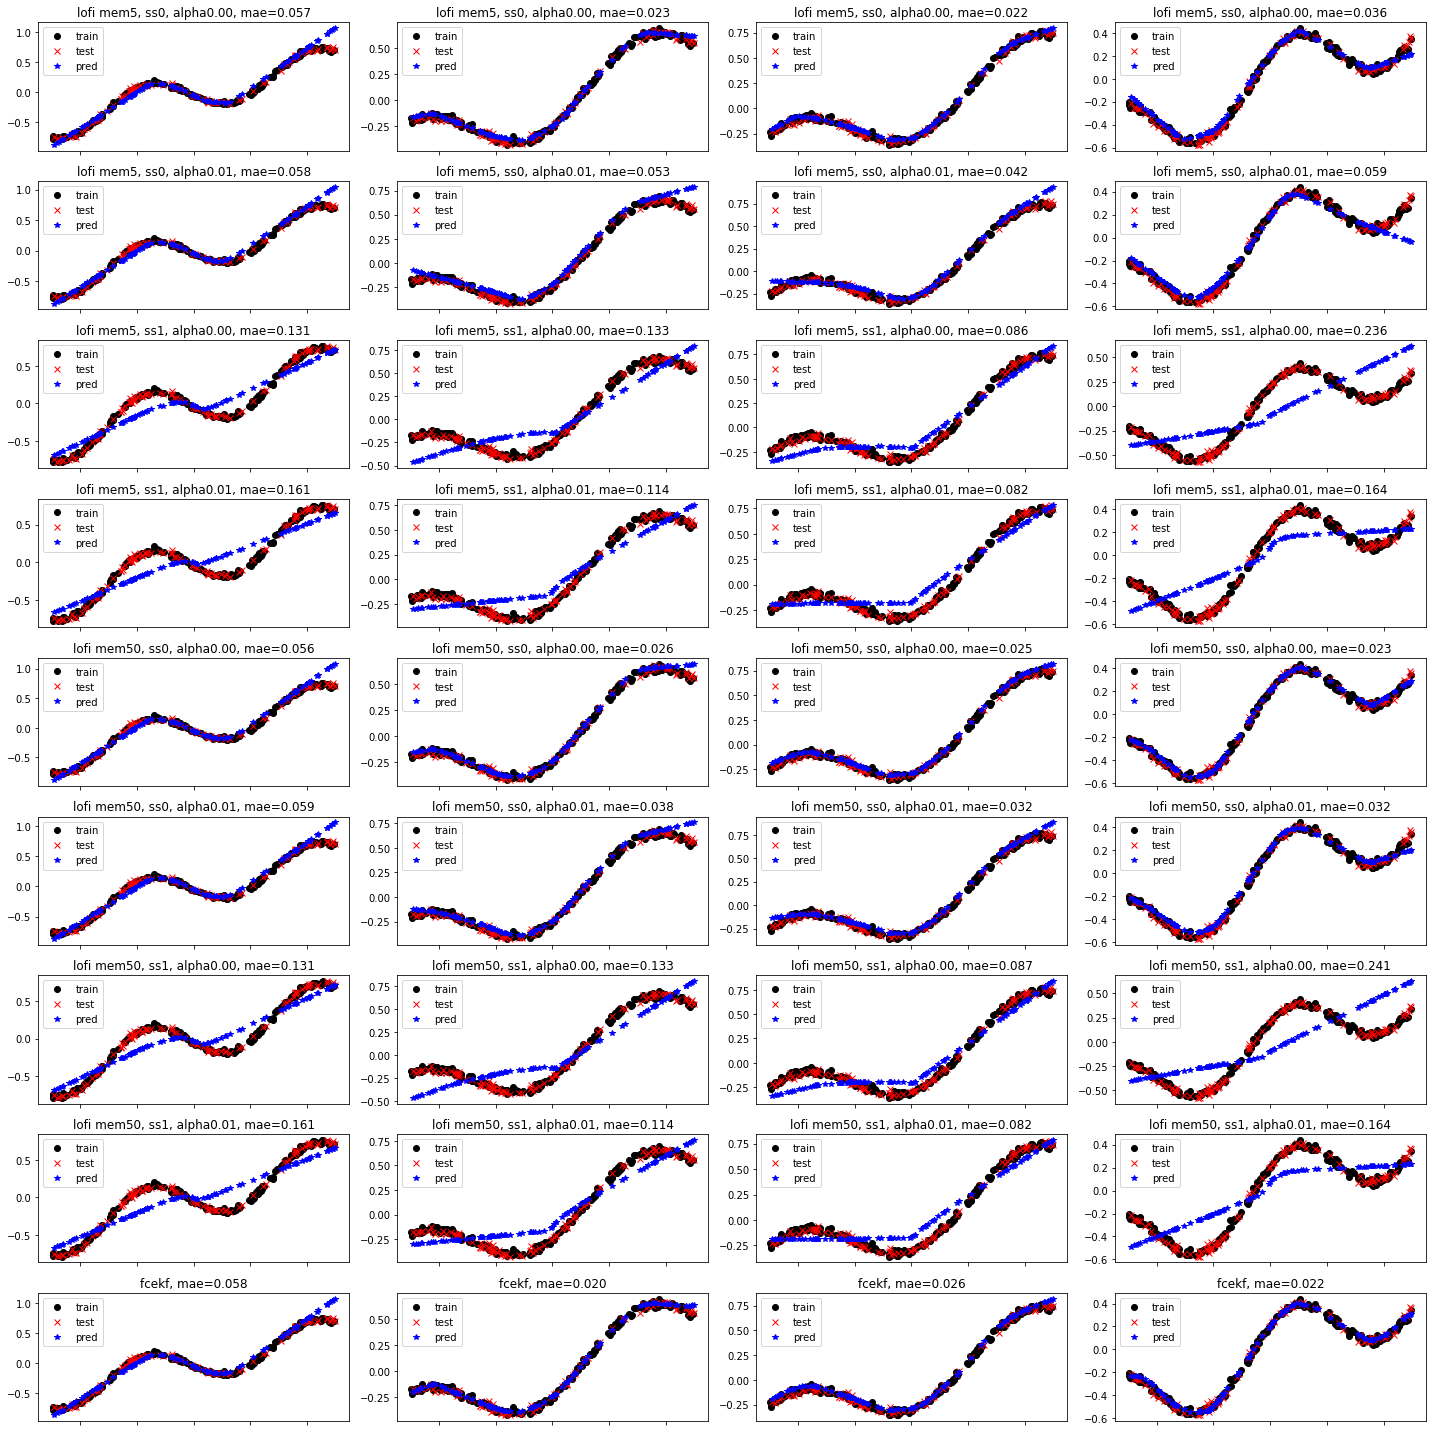

In [56]:
def plot_pred(Xtr, ytr, Xte, yte, yhat, ttl, ax=None):
    if ax is None:
        fig, ax = plt.subplot()    
    ax.plot(Xtr, ytr, 'o', color="black", label='train')
    ax.plot(Xte, yte, 'x', color="red", label='test')
    ax.plot(Xte, yhat, '*', color="blue", label='pred')
    ax.set_xticklabels([])
    ax.legend()
    ax.set_title(ttl)


def plot_pred_task(task, outputs, ax, name=''):
    times = jnp.where(train_id_seq == task)
    last_time = times[0][-1]
    yhat = outputs['pred_test_current_task'][last_time,:]
    rmse = outputs['rmse_test_current_task'][last_time]
    mae = outputs['mae_test_current_task'][last_time]
    #ttl = 'method {:s}, task {:d}, time {:d}, rmse {:0.3f}'.format(name, task, last_time, rmse)
    #ttl = '{:s},  rmse {:0.3f}, mae {:0.3f}'.format(name, rmse, mae)
    ttl = '{:s}, mae={:0.3f}'.format(name,  mae)
    plot_pred(X_train_tasks[task], Y_train_tasks[task], X_test_tasks[task], Y_test_tasks[task], yhat, ttl, ax)


nmethods = len(method_list)
fig, axs = plt.subplots(nmethods, ntasks, figsize=(20,20))
for method_num, method in enumerate(method_list):
    for task in range(ntasks):
        outputs = output_list[method_num]
        plot_pred_task(task, outputs, axs[method_num, task], method)
fig.tight_layout()
    